# PCA and SVD to understand dimensonality in Lending Club Data

- This data was downloaded from https://www.kaggle.com/wendykan/lending-club-loan-data
- Some resources used are below. 
#### Resource for SVD http://web.mit.edu/be.400/www/SVD/Singular_Value_Decomposition.htm
#### Resource for SVD with sparse matrices http://maheshakya.github.io/gsoc/2014/05/18/preparing-a-bench-marking-data-set-using-singula-value-decomposition-on-movielens-data.html
#### Resource for PCA http://sebastianraschka.com/Articles/2015_pca_in_3_steps.html
#### Resource for PCA/SVD and collaborative filtering http://infolab.stanford.edu/~ullman/mmds/ch11.pdf

>This data contains information on loans originated on the Lengin Club platform between 2007 and 2015. In order to investigate this data, the following assumptions and alterations were performed below.
- 1) Loans from all years were grouped into two sections, paid off loans and default/charged off loans. (Default/Charged off means a person has gone >120 days without payment. Lending Club claims they have on average 10% recoveries from this group. However, we will treat the recoveries here are 0% for a more aggressive analysis).
- 2) Columns that are not numerical were dropped in order to perform SVD and PC
- 3) Data was normalized using standard scalers (mean = 0, variance =1). 
- 4) Random sampling on the original matrix was used for SVD due to resource constraints on my local machine.
- 5) Important features from the original matrix were computed from the eigenvectors and eigenvalues results from SVD.
- 6) To understand the difference the number of principal components needed between SVD and PCA, a t-test was performed on the sum of median values from each feature.
- 7) Prediction was performed using a cross-validation approach and SVD. Test data was projected onto trained eigenvectors and the euclidean distance taken to understand group prediction. 

### Overall
>From a start of 33 components in each loan group,
- SVD identified 18 components to explain 90% of the variance for paid off loans while PCA identified 16 components.
- SVD identified 22 features to explain 90% of the variance for default/charged off loans while PCA identified 19 components.
- **This difference is likely due to the fact that PCA used the entire original matrix while SVD used random samples of size 10,000***

- For prediction, accuracy for the 'Paid Off' loan group ranged from 64%-75% with training size of 1-10% of the total matrix (restricted due to resource constraints)
- Accuracy for the 'Default/Charged off group' ranged from 76%-86% with training size of 5%-50% of the total matrix.


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
%pylab inline
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from math import sqrt
from scipy.stats import t
from sklearn.preprocessing import StandardScaler
import operator
from sklearn.utils import shuffle

Populating the interactive namespace from numpy and matplotlib



# LoanStatNew	Description

**addr_state**	The state provided by the borrower in the loan application

**annual_inc**	The self-reported annual income provided by the borrower during registration.

**annual_inc_joint**	The combined self-reported annual income provided by the co-borrowers during registration

**application_type**	Indicates whether the loan is an individual application or a joint application with two co-borrowers

**collection_recovery_fee**	post charge off collection fee

**collections_12_mths_ex_med**	Number of collections in 12 months excluding medical collections

**delinq_2yrs**	The number of 30+ days past-due incidences of delinquency in the borrower's credit file for the past 2 years

**desc**	Loan description provided by the borrower

**dti**	A ratio calculated using the borrower’s total monthly debt payments on the total debt obligations, excluding mortgage and the requested LC loan, divided by the borrower’s self-reported monthly income.

**dti_joint**	A ratio calculated using the co-borrowers' total monthly payments on the total debt obligations, excluding mortgages and the requested LC loan, divided by the co-borrowers' combined self-reported monthly income

**earliest_cr_line**	The month the borrower's earliest reported credit line was opened

**emp_length**	Employment length in years. Possible values are between 0 and 10 where 0 means less than one year and 10 means ten or more years. 

**emp_title**	The job title supplied by the Borrower when applying for the loan.*

**fico_range_high**	The upper boundary range the borrower’s FICO at loan origination belongs to.

**fico_range_low**	The lower boundary range the borrower’s FICO at loan origination belongs to.

**funded_amnt	**The total amount committed to that loan at that point in time.

**funded_amnt_inv**	The total amount committed by investors for that loan at that point in time.

**grade**	LC assigned loan grade

**home_ownership**	The home ownership status provided by the borrower during registration. Our values are: RENT, OWN, MORTGAGE, OTHER.

**id**	A unique LC assigned ID for the loan listing.

**initial_list_status**	The initial listing status of the loan. Possible values are – W, F

**inq_last_6mths**	The number of inquiries in past 6 months (excluding auto and mortgage inquiries)

**installment**	The monthly payment owed by the borrower if the loan originates.

**int_rate**	Interest Rate on the loan

**is_inc_v**	Indicates if income was verified by LC, not verified, or if the income source was verified

**issue_d**	The month which the loan was funded

**last_credit_pull_d**	The most recent month LC pulled credit for this loan

**last_fico_range_high**	The upper boundary range the borrower’s last FICO pulled belongs to.

**last_fico_range_low**	The lower boundary range the borrower’s last FICO pulled belongs to.

**last_pymnt_amnt**	Last total payment amount received

**last_pymnt_d**	Last month payment was received

**loan_amnt**	The listed amount of the loan applied for by the borrower. If at some point in time, the credit department reduces the loan amount, then it will be reflected in this value.

**loan_status**	Current status of the loan

**member_id**	A unique LC assigned Id for the borrower member.

**mths_since_last_delinq**	The number of months since the borrower's last delinquency.

**mths_since_last_major_derog**	Months since most recent 90-day or worse rating

**mths_since_last_record**	The number of months since the last public record.

**next_pymnt_d**	Next scheduled payment date

**open_acc**	The number of open credit lines in the borrower's credit file.

**out_prncp**	Remaining outstanding principal for total amount funded

**out_prncp_inv**	Remaining outstanding principal for portion of total amount funded by investors

**policy_code**	"publicly available policy_code=1
new products not publicly available policy_code=2"

**pub_rec**	Number of derogatory public records

**purpose**	A category provided by the borrower for the loan request. 

**pymnt_plan**	Indicates if a payment plan has been put in place for the loan

**recoveries**	post charge off gross recovery

**revol_bal**	Total credit revolving balance

**revol_util**	Revolving line utilization rate, or the amount of credit the borrower is using relative to all available revolving credit.

**sub_grade**	LC assigned loan subgrade

**term**	The number of payments on the loan. Values are in months and can be either 36 or 60.

**title**	The loan title provided by the borrower

**total_acc**	The total number of credit lines currently in the borrower's credit file

**total_pymnt**	Payments received to date for total amount funded

**total_pymnt_inv**	Payments received to date for portion of total amount funded by investors

**total_rec_int**	Interest received to date

**total_rec_late_fee**	Late fees received to date

**total_rec_prncp**	Principal received to date

**url**	URL for the LC page with listing data.

**verified_status_joint**	Indicates if the co-borrowers' joint income was verified by LC, not verified, or if the income source was verified

**zip_code**	The first 3 numbers of the zip code provided by the borrower in the loan application.

**open_acc_6m**	Number of open trades in last 6 months

**open_il_6m**	Number of currently active installment trades

**open_il_12m**	Number of installment accounts opened in past 12 months

**open_il_24m**	Number of installment accounts opened in past 24 months

**mths_since_rcnt_il**	Months since most recent installment accounts opened

**total_bal_il**	Total current balance of all installment accounts

**il_util**	Ratio of total current balance to high credit/credit limit on all install acct
	
**open_rv_12m**	Number of revolving trades opened in past 12 months

**open_rv_24m**	Number of revolving trades opened in past 24 months

**max_bal_bc**	Maximum current balance owed on all revolving accounts

**all_util**	Balance to credit limit on all trades

**total_rev_hi_lim**  	Total revolving high credit/credit limit

**inq_fi**	Number of personal finance inquiries

**total_cu_tl**	Number of finance trades

**inq_last_12m**	Number of credit inquiries in past 12 months

**acc_now_delinq**	The number of accounts on which the borrower is now delinquent.

**tot_coll_amt**	Total collection amounts ever owed

**tot_cur_bal**	Total current balance of all accounts
	
	* Employer Title replaces Employer Name for all loans listed after 9/23/2013

In [2]:
## Specify the data types to speed up the .csv reading

loan_data_df = pd.read_csv('loan.csv',dtype={'id':pd.np.int64,'lean_amnt':np.float64,'funded_amnt_inv':np.float64})

/Users/jonathanhilgart/anaconda/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2723: DtypeWarning: Columns (19,55) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
loan_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 887379 entries, 0 to 887378
Data columns (total 74 columns):
id                             887379 non-null int64
member_id                      887379 non-null int64
loan_amnt                      887379 non-null float64
funded_amnt                    887379 non-null float64
funded_amnt_inv                887379 non-null float64
term                           887379 non-null object
int_rate                       887379 non-null float64
installment                    887379 non-null float64
grade                          887379 non-null object
sub_grade                      887379 non-null object
emp_title                      835922 non-null object
emp_length                     887379 non-null object
home_ownership                 887379 non-null object
annual_inc                     887375 non-null float64
verification_status            887379 non-null object
issue_d                        887379 non-null object
loan_status          

In [4]:
### The total amount of outstanding principal on the loan. If this is equal to 0, then the loan has been repaid
loan_data_df['out_prncp'].head(10)

0       0.00
1       0.00
2       0.00
3       0.00
4     766.90
5       0.00
6    1889.15
7       0.00
8       0.00
9       0.00
Name: out_prncp, dtype: float64

In [5]:
##The total amount of payment received on the loan
loan_data_df['total_pymnt'].head(10)

0     5861.071414
1     1008.710000
2     3003.653644
3    12226.302212
4     3242.170000
5     5631.377753
6     8136.840000
7     3938.144334
8      646.020000
9     1476.190000
Name: total_pymnt, dtype: float64

In [6]:
## Check the next scheduled payment date for each loan. If NaN, then this loan has been paid off.

loan_data_df['next_pymnt_d'].head(10)

0         NaN
1         NaN
2         NaN
3         NaN
4    Feb-2016
5         NaN
6    Feb-2016
7         NaN
8         NaN
9         NaN
Name: next_pymnt_d, dtype: object

In [7]:
loan_data_df.loan_status[loan_data_df.loan_status=='Fully Paid'].count()

207723

# This analysis will focus only on the loans that are fully paid vs loans that have defaulted or charged off (this means a loan has gone >120 days without a payment).


In [8]:
loan_data_df.loan_status[loan_data_df.loan_status=='Fully Paid'].count()

207723

In [9]:
loan_data_df.loan_status[loan_data_df.loan_status=='Default'].count()

1219

In [10]:
loan_data_df.loan_status[loan_data_df.loan_status=='Charged Off'].count()

45248

- 207,723 loans that were fully paid off
- 45,248 loans that were charged off
- 1,219 loans that were defaulted on

I am going to create a new df with loans that are fully paid, defaulted, or charged off.

In [11]:
#df = df.drop(df[<some boolean condition>].index)
#loan_data_dropped_df = loan_data_df.copy()

fully_paid = loan_data_df[loan_data_df.loan_status=='Fully Paid']
default = loan_data_df[loan_data_df.loan_status=='Default']
charged_off = loan_data_df[loan_data_df.loan_status=='Charged Off']
#loan_data_dropped_df = loan_data_df[fully_paid & default & charged_off]

loan_data_dropped_df = pd.concat((fully_paid,default,charged_off))
loan_data_dropped_df.describe()


/Users/jonathanhilgart/anaconda/lib/python3.5/site-packages/numpy/lib/function_base.py:3834: RuntimeWarning: Invalid value encountered in percentile
  RuntimeWarning)


,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,dti,delinq_2yrs,...,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m
count,2.541900e+05,2.541900e+05,254190.000000,254190.000000,254190.000000,254190.000000,254190.000000,2.541900e+05,254190.000000,254190.000000,...,144.000000,126.000000,144.000000,144.000000,144.000000,144.000000,1.904640e+05,144.000000,144.000000,144.000000
mean,1.234067e+07,1.366169e+07,13570.590897,13530.210374,13437.613928,13.776014,418.273195,7.251051e+04,16.560534,0.250533,...,36462.312500,73.657937,1.673611,3.555556,5517.340278,58.945139,2.969485e+04,1.256944,2.097222,2.625000
std,1.479726e+07,1.576494e+07,8133.386869,8111.020870,8129.476448,4.404088,244.912615,5.878545e+04,7.794390,0.742390,...,38137.563875,23.074812,1.629406,2.932284,4507.604776,20.356957,2.949980e+04,1.792551,3.903234,4.057067
min,5.473400e+04,7.069900e+04,500.000000,500.000000,0.000000,5.320000,15.690000,3.000000e+03,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,7.900000,0.000000e+00,0.000000,0.000000,-4.000000
25%,1.462514e+06,1.709671e+06,7250.000000,7200.000000,7200.000000,10.740000,239.560000,4.500000e+04,10.770000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,6.321818e+06,7.660992e+06,12000.000000,12000.000000,11975.000000,13.530000,365.230000,6.200000e+04,16.220000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,1.655208e+07,1.858534e+07,18250.000000,18125.000000,18000.000000,16.550000,547.550000,8.700000e+04,22.010000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max,6.860466e+07,7.350742e+07,35000.000000,35000.000000,35000.000000,28.990000,1424.570000,8.706582e+06,57.140000,29.000000,...,249212.000000,129.200000,8.000000,21.000000,22279.000000,102.800000,2.013133e+06,9.000000,21.000000,19.000000


## Loan_data_dropped_df now contains loans that are fully paid, defaulted, charged off, and only contains numeric columns.

In [12]:
loan_data_dropped_df.loan_status.unique()

array(['Fully Paid', 'Default', 'Charged Off'], dtype=object)

In [13]:
#Verify the number of loans we have
print(loan_data_dropped_df.loan_status.count(), \
      (loan_data_df.loan_status[loan_data_df.loan_status=='Charged Off'].count() \
       +loan_data_df.loan_status[loan_data_df.loan_status=='Default'].count() \
       +loan_data_df.loan_status[loan_data_df.loan_status=='Fully Paid'].count()))

254190 254190


## Next let's address out null values

In [14]:
##which columns have null data
#loan_data_dropped_df=loan_data_dropped_df.fillna(0)
pd.isnull(loan_data_dropped_df).any()

id                             False
member_id                      False
loan_amnt                      False
funded_amnt                    False
funded_amnt_inv                False
term                           False
int_rate                       False
installment                    False
grade                          False
sub_grade                      False
emp_title                       True
emp_length                     False
home_ownership                 False
annual_inc                     False
verification_status            False
issue_d                        False
loan_status                    False
pymnt_plan                     False
url                            False
desc                            True
purpose                        False
title                           True
zip_code                       False
addr_state                     False
dti                            False
delinq_2yrs                    False
earliest_cr_line               False
i

## Next, fill all null values with zero. The fields that have null values are fields that Lending Club did not check (or did not come up in the credit report). Therefore, it is appropriate to impute zeros for these records.

In [15]:
#dff.fillna(dff.mean())

In [16]:
#This takes ~10 minutes to run
loan_data_dropped_df=loan_data_dropped_df.fillna(0)

# Next, drop the columns where the majority of values are =0. This means that less than 5% of the column contains data. 

- This will be annual_inc_joint
- dti_joint
- open_acc_6m 
- open_il_6m
- open_il_12m
- open_il_24m
- mths_since_rcnt_il
- total_bal_il
- il_util
- open_rv_12m
- open_rv_24m
- max_bal_bc
- all_util
- inq_fi
- total_cu_tl
- inq_last_12m 

In [17]:
loan_data_removecol_df = loan_data_dropped_df.drop(['il_util','open_rv_12m','open_rv_24m','max_bal_bc','all_util',\
                                                 'inq_fi','total_cu_tl','inq_last_12m','open_il_6m', \
                                                 'open_il_12m','open_il_24m','mths_since_rcnt_il','annual_inc_joint',\
                                                   'dti_joint','open_acc_6m','total_bal_il'] , axis=1)

### For the next part of this analysis, we will primarily look at either loans that have defaulted or charged off vs loans that have been paid off.

In [18]:
loan_removecol_paid_df = loan_data_removecol_df[loan_data_removecol_df.loan_status=='Fully Paid']
charged_off = loan_data_removecol_df[loan_data_removecol_df.loan_status=='Charged Off']
default = loan_data_removecol_df[loan_data_removecol_df.loan_status=='Default']
loan_remove_col_default_chargedoff_df =pd.concat((charged_off,default))

In [19]:
loan_removecol_paid_df.id.count()

207723

In [20]:
loan_remove_col_default_chargedoff_df.id.count()

46467

- loan_removecol_paid_df contains loans that have been fully paid.
- loan_remove_col_default_chargedoff_df contains loans that are charged off or defaulted (have gone >120 days without payment)

# For SVD, we can only use columns that have numeric data. I will drop everything else.

In [21]:
loan_remove_col_default_chargedoff_df =loan_remove_col_default_chargedoff_df.select_dtypes(include=['float64','int64'])


In [22]:
loan_removecol_paid_df = loan_removecol_paid_df.select_dtypes(include=['float64','int64'])

In [23]:
#loan_removecol_paid_df
loan_remove_col_default_chargedoff_df.describe()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,dti,delinq_2yrs,...,recoveries,collection_recovery_fee,last_pymnt_amnt,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim
count,4.646700e+04,4.646700e+04,46467.000000,46467.000000,46467.000000,46467.000000,46467.000000,4.646700e+04,46467.000000,46467.000000,...,46467.000000,46467.000000,46467.000000,46467.000000,46467.000000,46467.0,46467.000000,46467.000000,4.646700e+04,4.646700e+04
mean,1.139438e+07,1.271197e+07,14573.018486,14528.669271,14411.372330,16.019092,441.073219,6.512892e+04,18.444234,0.278757,...,867.436067,91.206597,454.998240,0.008285,8.341985,1.0,0.003938,104.953042,8.964967e+04,2.070076e+04
std,1.231704e+07,1.316284e+07,8391.928489,8366.116179,8390.706853,4.301283,246.793319,5.686452e+04,7.950591,0.799408,...,1559.671060,253.065131,650.022043,0.096177,19.478848,0.0,0.070703,1152.924656,1.225158e+05,2.499265e+04
min,5.716700e+04,8.035300e+04,900.000000,900.000000,0.000000,5.420000,21.620000,4.080000e+03,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.000000,0.000000,0.000000e+00,0.000000e+00
25%,1.593010e+06,1.847868e+06,8000.000000,8000.000000,8000.000000,13.050000,265.810000,4.000000e+04,12.610000,0.000000,...,0.000000,0.000000,237.850000,0.000000,0.000000,1.0,0.000000,0.000000,8.008500e+03,5.100000e+03
50%,6.754617e+06,8.135759e+06,12700.000000,12600.000000,12400.000000,15.800000,391.170000,5.600000e+04,18.380000,0.000000,...,16.250000,0.000000,375.880000,0.000000,0.000000,1.0,0.000000,0.000000,3.663000e+04,1.580000e+04
75%,1.563112e+07,1.759362e+07,20000.000000,20000.000000,19975.000000,18.920000,573.320000,7.800000e+04,24.140000,0.000000,...,1214.165000,24.915500,568.700000,0.000000,0.000000,1.0,0.000000,0.000000,1.378180e+05,2.890000e+04
max,6.051698e+07,6.453775e+07,35000.000000,35000.000000,35000.000000,28.990000,1424.570000,8.706582e+06,39.980000,18.000000,...,33520.270000,7002.190000,34833.350000,4.000000,152.000000,1.0,5.000000,95806.000000,3.437283e+06,1.998700e+06


In [24]:
loan_removecol_paid_df.describe()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,dti,delinq_2yrs,...,recoveries,collection_recovery_fee,last_pymnt_amnt,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim
count,2.077230e+05,2.077230e+05,207723.000000,207723.000000,207723.000000,207723.000000,207723.000000,2.077230e+05,207723.000000,207723.000000,...,207723.0,207723.0,207723.000000,207723.000000,207723.000000,207723.0,207723.000000,2.077230e+05,2.077230e+05,2.077230e+05
mean,1.255236e+07,1.387413e+07,13346.350910,13306.858172,13219.787151,13.274244,413.172899,7.416175e+04,16.139156,0.244219,...,0.0,0.0,7770.242299,0.006432,8.135719,1.0,0.002941,1.630065e+02,1.066268e+05,2.259691e+04
std,1.528915e+07,1.628268e+07,8057.388288,8035.909683,8053.805339,4.268371,244.199337,5.908066e+04,7.696190,0.728877,...,0.0,0.0,7508.104201,0.087638,19.369796,0.0,0.058101,2.013550e+04,1.491762e+05,2.932998e+04
min,5.473400e+04,7.069900e+04,500.000000,500.000000,0.000000,5.320000,15.690000,3.000000e+03,0.000000,0.000000,...,0.0,0.0,0.000000,0.000000,0.000000,1.0,0.000000,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.439717e+06,1.684432e+06,7200.000000,7150.000000,7000.000000,10.160000,234.360000,4.500000e+04,10.420000,0.000000,...,0.0,0.0,1555.190000,0.000000,0.000000,1.0,0.000000,0.000000e+00,0.000000e+00,0.000000e+00
50%,6.225193e+06,7.450306e+06,12000.000000,12000.000000,11725.000000,13.110000,360.080000,6.416200e+04,15.750000,0.000000,...,0.0,0.0,5749.590000,0.000000,0.000000,1.0,0.000000,0.000000e+00,3.866600e+04,1.602100e+04
75%,1.721285e+07,1.922597e+07,18000.000000,18000.000000,18000.000000,15.810000,540.560000,9.000000e+04,21.480000,0.000000,...,0.0,0.0,11663.590000,0.000000,0.000000,1.0,0.000000,0.000000e+00,1.712135e+05,3.120000e+04
max,6.860466e+07,7.350742e+07,35000.000000,35000.000000,35000.000000,28.990000,1409.990000,7.141778e+06,57.140000,29.000000,...,0.0,0.0,36475.590000,6.000000,159.000000,1.0,5.000000,9.152545e+06,8.000078e+06,2.013133e+06


# Let's look at the variables plotted against eachother.

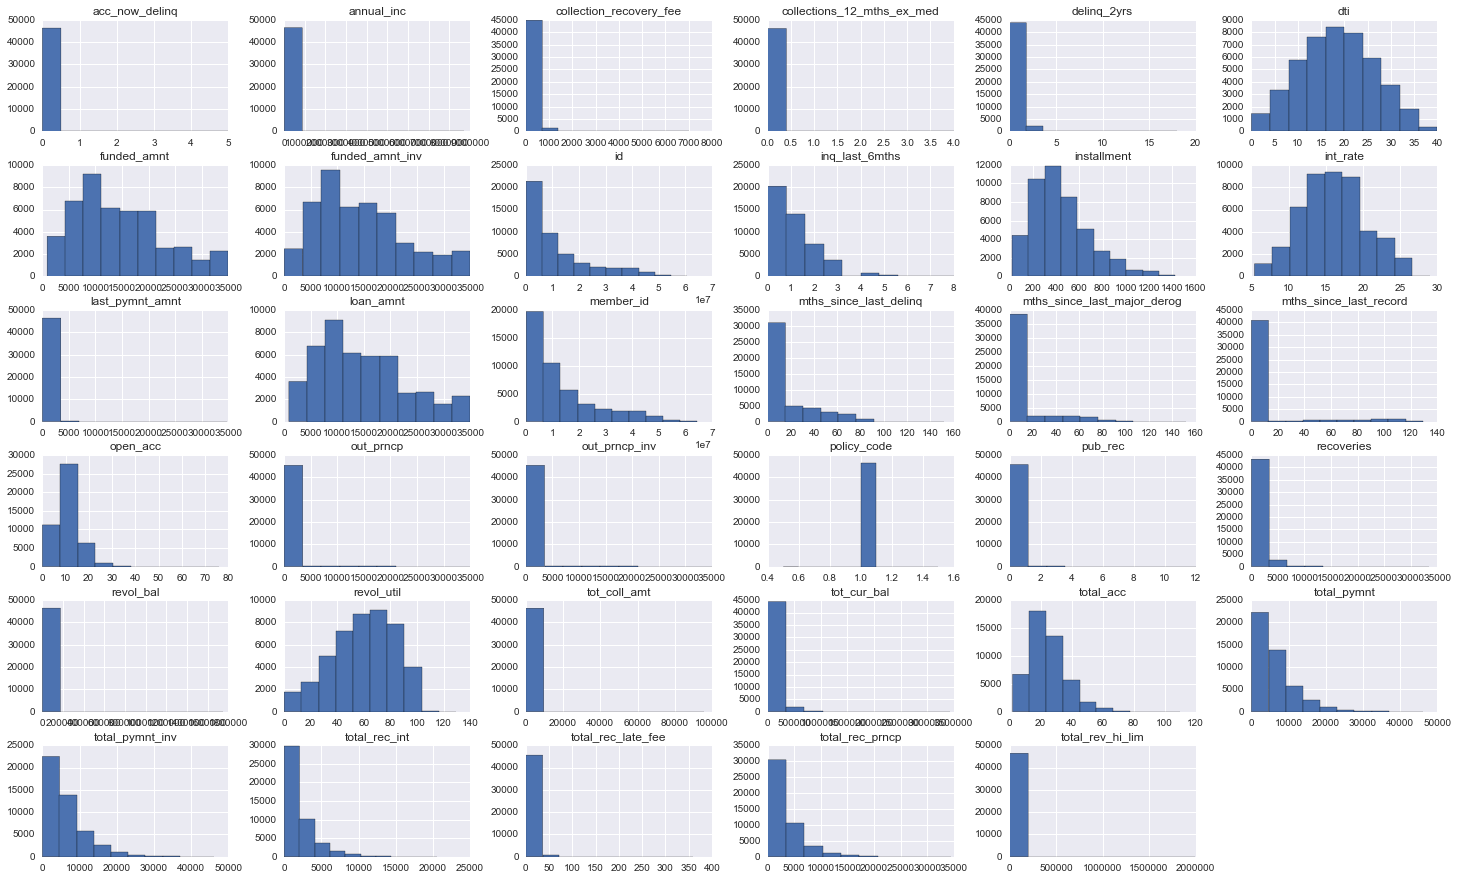

In [25]:
#default or charged off

loan_remove_col_default_chargedoff_df.hist(figsize=(25,15));

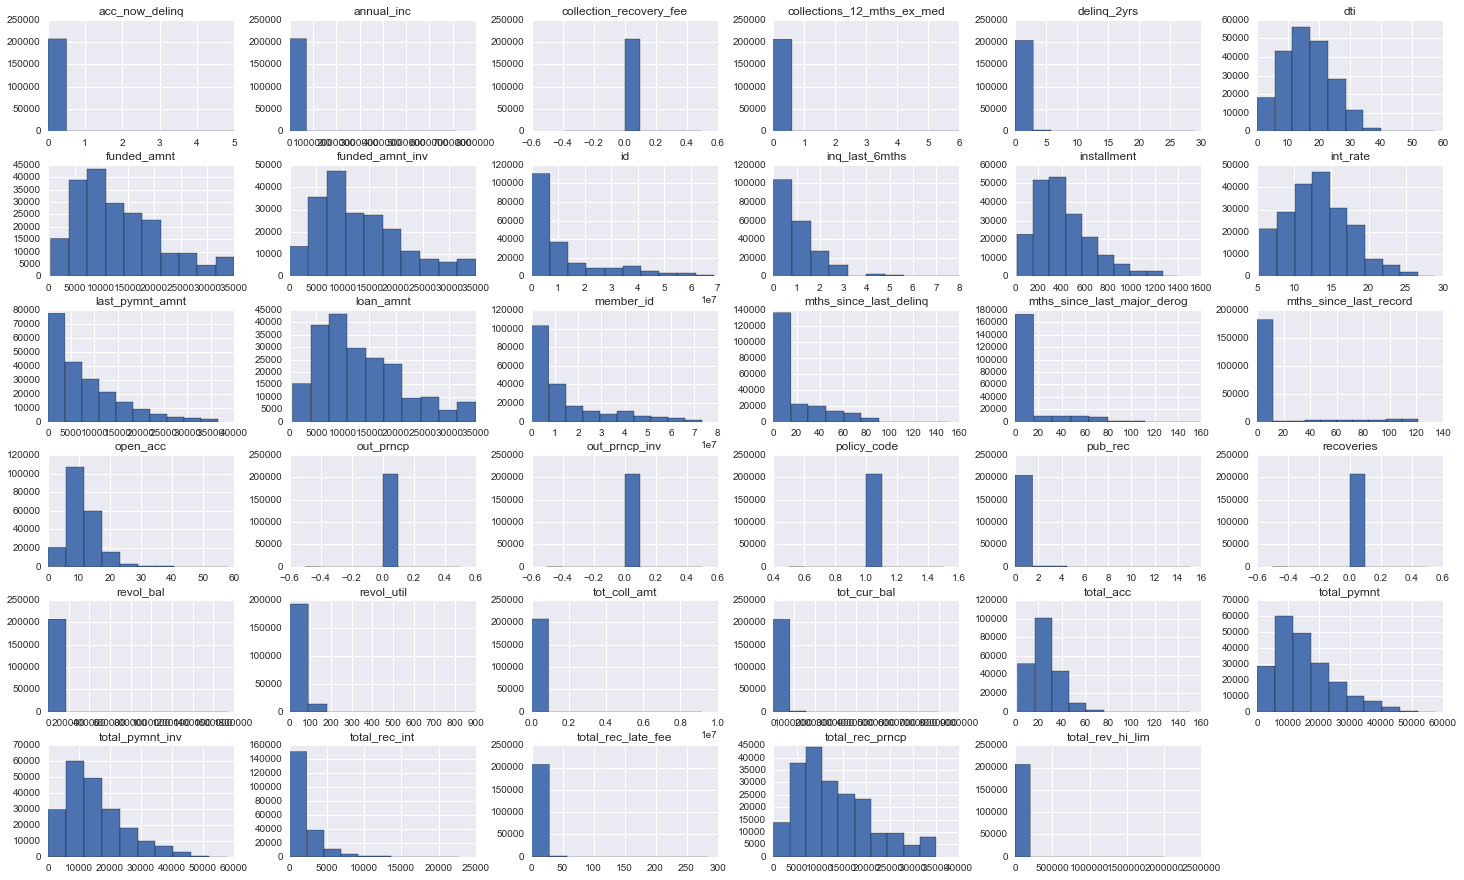

In [26]:
#Paid off loans
loan_removecol_paid_df.hist(figsize=(25,15));

## Let's time how long SVD decomposition will take.

In [27]:
def random_matrix(rows,cols):
    """Create a random matrix of size rows by cols"""
    matrix = np.array([np.random.randint(-1000,rows) for rows in range(rows*cols)])
    matrx = matrix.resize(rows,cols)
    matrix = np.array(matrix)
    return matrix

In [28]:
def timer(matrix):
    '''Time the SVD of a different matrix sizes'''
    start = time.clock()
    #print(start,'start')
    size = len(matrix) ##number of rows
    u, d, v = np.linalg.svd(matrix)

    
    end = time.clock()
    #print(svd, ' svd')
    #print(end,'end')
    #print("It took ",end-start, "seconds to create the feature space and sample space with size {}".format(size))
    
    return(end-start , size)

In [29]:
import time

In [30]:
test = [random_matrix(i,i) for i in range(2,4000,50)]

In [31]:
#timing_data_x = [timer(item)[0] for item in test]
#timing_data_y = [timer(item)[1] for item in test]
timing_data = [timer(item) for item in test]

In [32]:
timing_data = pd.DataFrame(data=timing_data,columns=['time','size'])
timing_data.head()

,time,size
0,0.011372,2
1,0.008232,52
2,0.011276,102
3,0.012513,152
4,0.021348,202


In [33]:
import seaborn as sns
%pylab inline

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


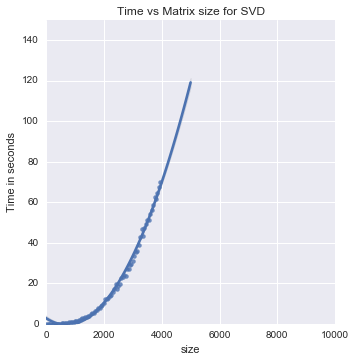

In [34]:
# fit this to an exponential formula 
#np.polyfit(timing_data)

sns.lmplot(x='size',y='time',data=timing_data,order=2)
plt.title('Time vs Matrix size for SVD')
plt.ylabel('Time in seconds')
plt.ylim(0,150)
plt.xlim(0,10000);

# It takes nearly a minute to run SVD on a matrix of 4k rows by 4k columns. Next, find the equation of this function to determine how long our SVD will take.

In [35]:
#find the equation
#http://docs.scipy.org/doc/numpy/reference/generated/numpy.polyfit.html
np.polyfit(timing_data['size'],timing_data.time,deg=2)


array([  6.50203272e-06,  -9.23702328e-03,   2.77904378e+00])

## The equation is $.000006502*x^2 - .00923*x + 2.1$
- Therefore, if x = 4000, y = ~56 seconds
- If x = 210,000 (for the paid off loan matrix)  y = 232756 seconds or ~3879 minutes or ~64 hours
- if x = 46,467 (for default / charged off matrix), y = 11123 seconds or ~185 minutes or ~ 3 hours

In [36]:
def svd_timing(size): return (.00000531402857*size**2- .00759*size+2.1)

In [37]:
svd_timing(46467)

11123.370778778284

   #    In order to reduce the size of these matrices, random sampling will be performed on each dataframe; SVD will then be performed on each of these sub-matrices to determine how much we can reduce the dimensionality of each matrix group (paid off loans and deafult/charged off loans). In addition, the most important features from the original matrix will be graphed. 

>Process
- Normalize the original matrices using standard scalers. This centers the data with mean at 0 and variance =1.
- Compute the SVD of the matrix sample
- Determine how many features you need to capture x% of the variance.
- Drop the rest of the singular values and compare across groups.
- Determine the index of the largest (aboslute value) number in each eigenvector. This index corresponds to the index of the features from the original matrix. Multiply this eigenvector element by the corresponding eigenvalues to receive a magnitude of importance.

>For both of these dataframes,  id and the member id columns might skew the svd since these columns are not associated to an attribute of the borrower. I will also drop these columns to better understand the variance of the underlying data. 




In [38]:
#The three dataframes we are working with loan_removecol_paid_df ,
#loan_remove_col_default_chargedoff_df and total_remove_col_df

#The third dataframe constructed here. 
copy_loan_removecol_paid_df = loan_removecol_paid_df.copy()
copy_loan_remove_col_default_chargedoff_df = loan_remove_col_default_chargedoff_df.copy()

copy_loan_removecol_paid_df['paid_off']=1
copy_loan_remove_col_default_chargedoff_df['paid_off']=0
total_remove_col_df = pd.concat([copy_loan_remove_col_default_chargedoff_df,copy_loan_removecol_paid_df])



# For variables where the unit vector = 0, set these NaN's = 0.
loan_removecol_paid_df.fillna(0,inplace=True)
loan_remove_col_default_chargedoff_df.fillna(0,inplace=True)
total_remove_col_df.fillna(0,inplace=True)


#Normalize using standard scalar.

scaler_total = StandardScaler().fit(total_remove_col_df)
normal_total_remove_col_df = scaler_total.transform(total_remove_col_df)

scaler_paid_off = StandardScaler().fit(loan_removecol_paid_df)
normal_loan_removecol_paid_df = scaler_paid_off.transform(loan_removecol_paid_df)

scaler_default_chargedoff = StandardScaler().fit(loan_remove_col_default_chargedoff_df)
normal_loan_remove_col_default_chargedoff_df = scaler_default_chargedoff.transform(loan_remove_col_default_chargedoff_df)

## Convert back to a dataframe
normal_loan_remove_col_default_chargedoff_df= pd.DataFrame(normal_loan_remove_col_default_chargedoff_df,columns=['id', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv',\
       'int_rate', 'installment', 'annual_inc', 'dti', 'delinq_2yrs', \
       'inq_last_6mths', 'mths_since_last_delinq', 'mths_since_last_record',\
       'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc',\
       'out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv',\
       'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries',\
       'collection_recovery_fee', 'last_pymnt_amnt',\
       'collections_12_mths_ex_med', 'mths_since_last_major_derog',\
       'policy_code', 'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal',\
       'total_rev_hi_lim'])


normal_loan_removecol_paid_df  = pd.DataFrame(normal_loan_removecol_paid_df ,columns=['id', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv',\
       'int_rate', 'installment', 'annual_inc', 'dti', 'delinq_2yrs', \
       'inq_last_6mths', 'mths_since_last_delinq', 'mths_since_last_record',\
       'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc',\
       'out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv',\
       'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries',\
       'collection_recovery_fee', 'last_pymnt_amnt',\
       'collections_12_mths_ex_med', 'mths_since_last_major_derog',\
       'policy_code', 'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal',\
       'total_rev_hi_lim'])

normal_total_remove_col_df = pd.DataFrame(normal_total_remove_col_df ,columns=['id', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv',\
       'int_rate', 'installment', 'annual_inc', 'dti', 'delinq_2yrs', \
       'inq_last_6mths', 'mths_since_last_delinq', 'mths_since_last_record',\
       'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc',\
       'out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv',\
       'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries',\
       'collection_recovery_fee', 'last_pymnt_amnt',\
       'collections_12_mths_ex_med', 'mths_since_last_major_derog',\
       'policy_code', 'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal',\
       'total_rev_hi_lim','paid_off'])

#Drop the member id and id columns. These columns do not add any information to our samples.
normal_loan_remove_col_default_chargedoff_df.drop(labels=['id','member_id'],axis=1,inplace=True)
normal_loan_removecol_paid_df.drop(labels = ['id','member_id'],axis=1,inplace=True)
normal_total_remove_col_df.drop(labels=['id','member_id'],axis=1,inplace=True)

#ALso remove member id and id columns for the pre-normalized data. THis will help with prediction.

total_remove_col_df = total_remove_col_df.drop(['member_id','id'],axis=1)
loan_remove_col_default_chargedoff_df  = loan_remove_col_default_chargedoff_df .drop(['member_id','id'],axis=1)
loan_removecol_paid_df = loan_removecol_paid_df .drop(['member_id','id'],axis=1)

In [39]:
def svd_variance_plot(trials, sample_size,dataframe,name_of_group,percent_variance=.90,prediction=False):
    """Take a number of trials of size sample_size from your dataframe. Compute SVD on these samples. Graph the
    variance captured by each eigenvalues across all samples. Return the principal components in your original dataframe.
    Graph a bar plot of the magnitude of each feature to maintain 90% of variance. 
    Can only take ten samples max. If prediction is True, will return only your u,d,V_T matrix."""
    
    if trials >10: ## This is done because there are not enough colors to graph!
        return ("You have too many trials. Please try again.")
    
    
    if prediction == True: ## we will only take one trial of the data and return v_t which maps to the sample space.
        
        trials =1
        
        df_sample = [dataframe.sample(sample_size) for item in range(trials)]
        
        list_of_columns_in_df = list(dataframe.columns)
        
        u, d, v_t = np.linalg.svd(df_sample[0], full_matrices=False)
        
        return u,d,v_t
        
    df_sample = [dataframe.sample(sample_size) for item in range(trials)]#Sample dataframe
    list_of_columns_in_df = list(dataframe.columns)
    
    u_list = []
    d_list = []
    v_t_list = []
    
    first_u=np.array([[]])
    first_d=np.array([[]])
    first_v_t=np.array([[]])
    
    
    
    colors = ['r','g','b','k','orange','navy','teal','maroon','w','m'] #colors for plotting
        
    for count,sample in enumerate(df_sample): ## SVD on the sample matrices
        
        u, d, v_t = np.linalg.svd(df_sample[count], full_matrices=False)
        u_list.append(u)
        d_list.append(d)
        v_t_list.append(v_t)
        
        if count == 0:
            first_u=u
            first_d=d
            first_v_t=v_t
        
        #Plot the magnitude of each eigenvalue across each sample 
        plt.plot(d_list[count],color=colors[count])
        plt.title("Percent variance captured by each eigenvalue for {} trials of size {} for the {} group".format(trials,sample_size,name_of_group))
        plt.ylabel('Magnitude of each eigenvalue')
        plt.xlabel('Number of eigenvalues')
    

    percent_diagonal = []
    
    for count,item in enumerate(d_list): ### calculate the percent of variance that each eigenvalue accounts for
        max_diagonal = sum(d_list[count])
        for diagonal in item:
            percent_diagonal.append(diagonal/max_diagonal)
        
 
    
    number_of_features_count = 1
    sum_of_variance = 0
    
    for count,item in enumerate(percent_diagonal): ## Go through the number of elements until your reach you percent variance desired
        sum_of_variance+=percent_diagonal[count]
        
        if sum_of_variance <percent_variance:
            number_of_features_count +=1
        elif sum_of_variance >= percent_variance: ## Continue to aggregate features until you reach this threshold
            print('The first {} eigenvalue(s)) account for {} percent of the variance in your matrix.'.format(number_of_features_count,sum_of_variance)," in your original matrix for your first sample. Note, there may be a difference between this number of the number of columns in the features graph due to duplicates.")
            #Principal components are given by the eigenvectors in V_T.
            #Go through each eigenvector and look for the max absolute value, the index of the max value maps to the 
            #importance of each feature for that index.
            
            if number_of_features_count ==1: ### There is only one feature that explains 90% of the variance of your data
                reconstructed_matrix = pd.DataFrame(first_u[:,:number_of_features_count]*first_d[number_of_features_count]) ## reconstruct the matrix into the concept space to find the principal components
                column_max = list(abs(reconstructed_matrix),axis=0)
                max_column = max(column_max[0])
                index_of_max_column = column_max.index(max_column)
                print('This feature corresponds to',list_of_columns_in_df[index_of_max_column]," in your original matrix for your first sample.\
                Note, there may be a difference between this number of the number of columns in the features graph due to duplicates.")
                print(" ")
                break
            else: ## This is only looking at the importance of eigenvalues/vectors from the first sample. 
                primary_eigenvectors = first_v_t
                column_abs = list(abs(primary_eigenvectors)) 
                ## Take the max number to determine the columns that contains the most information
                sorted_column_abs = []
                for eigenvector in column_abs:
                    sorted_column_abs.append(sorted(eigenvector,reverse=True))
                highest_ranked_columns = []
                features_and_weight = {}
                for count,eigenvector in enumerate(column_abs):
                    ### determine the index in the original matrix of the most important features
                    eigenvector = list(eigenvector)
                    max_number_in_eigenvector = max(eigenvector)
                    if count <number_of_features_count: 
                        ## find features until you meet the eplained variance threshold
                        index_abs_element =eigenvector.index(max_number_in_eigenvector)
                        ## index of the max value for each eigenvector
                        highest_ranked_columns.append(list_of_columns_in_df[index_abs_element] ) # Append the feature name
                        #that correspond to the largest element from the eigenvector
                        features_and_weight[list_of_columns_in_df[index_abs_element]] =(max_number_in_eigenvector*first_d[count])
                        #Find the magnitude by multiplying the eigenvector element by the corresponding eigenvalue
                    else: ## plot the features and their magnitude
                        plt.figure()
                        plt.figure(figsize=(15,5))
                        
                        plt.bar(range(len(features_and_weight)),features_and_weight.values(),align='center')
                        locs, labels = plt.xticks(range(len(features_and_weight)),features_and_weight.keys())
                        plt.setp(labels, rotation=90)
                        plt.ylabel('Magnitude of each feature importance for')
                        plt.title('Importance of each feature after decomposition for {}'.format(name_of_group));
                        break
                print("These are the features, {} , that account for > 90% variance in your original matrix for the first sample.\n".format(features_and_weight))
                print((" "))


                
                break
        else:
            pass
            
            
    
    

The first 21 eigenvalue(s)) account for 0.9012219050577158 percent of the variance in your matrix.  in your original matrix for your first sample. Note, there may be a difference between this number of the number of columns in the features graph due to duplicates.
These are the features, {'revol_util': 60.964008565740734, 'inq_last_6mths': 74.346291283371286, 'annual_inc': 44.035573031059407, 'acc_now_delinq': 86.764177826485493, 'paid_off': 42.766181977788591, 'out_prncp': 85.387592031748952, 'int_rate': 47.216233566313939, 'collections_12_mths_ex_med': 82.619401936731606, 'pub_rec': 77.313906638578132, 'tot_cur_bal': 47.476522468692849, 'total_rev_hi_lim': 66.272480852556555, 'total_acc': 36.953193891263545, 'total_rec_late_fee': 83.286514701071042, 'mths_since_last_major_derog': 44.97814547654194, 'mths_since_last_delinq': 47.857798541026511, 'total_pymnt': 94.105218461169841, 'delinq_2yrs': 60.666474715288892} , that account for > 90% variance in your original matrix for the first 

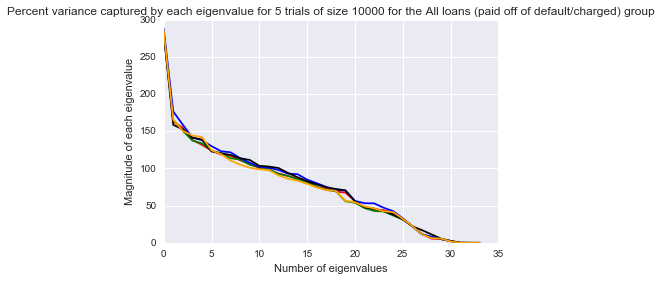

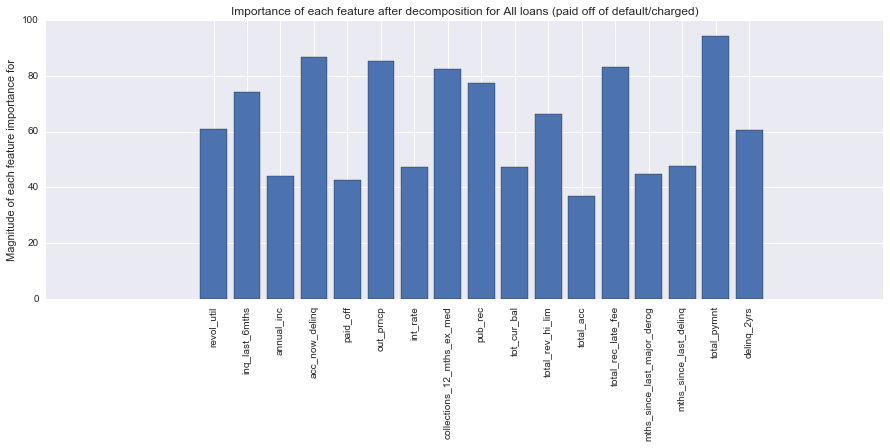

In [40]:
svd_variance_plot(5,10000,normal_total_remove_col_df,'All loans (paid off of default/charged)',.9)

The first 18 eigenvalue(s)) account for 0.9133310818343016 percent of the variance in your matrix.  in your original matrix for your first sample. Note, there may be a difference between this number of the number of columns in the features graph due to duplicates.
These are the features, {'revol_util': 58.310034515996833, 'inq_last_6mths': 75.914656854346987, 'annual_inc': 167.4374123512919, 'acc_now_delinq': 61.018164467038986, 'last_pymnt_amnt': 43.504523409457612, 'int_rate': 47.069138968337548, 'collections_12_mths_ex_med': 84.613077264068664, 'open_acc': 37.30379558501793, 'pub_rec': 79.562562709638527, 'tot_cur_bal': 36.285508810247592, 'funded_amnt': 95.190253193558704, 'total_rec_late_fee': 90.030471251014447, 'mths_since_last_delinq': 46.064266584520254} , that account for > 90% variance in your original matrix for the first sample.

 


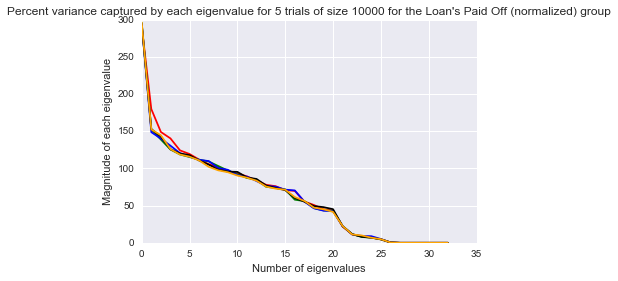

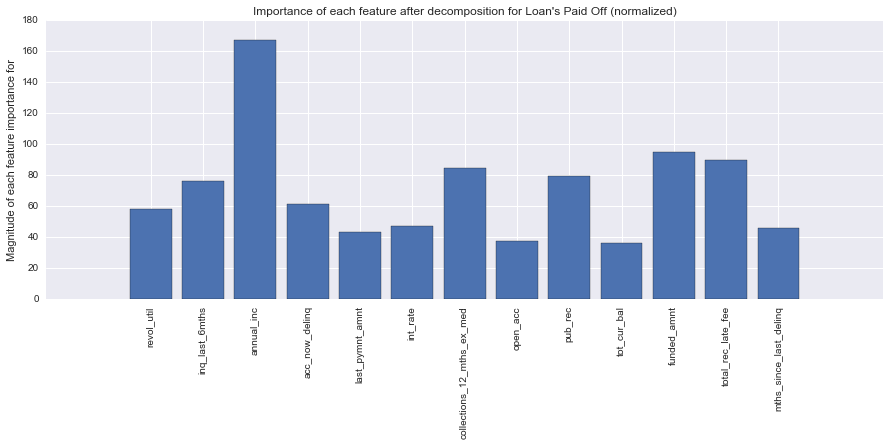

In [41]:
svd_variance_plot(5,10000,normal_loan_removecol_paid_df,"Loan's Paid Off (normalized)",.9)



The first 22 eigenvalue(s)) account for 0.9192146191127427 percent of the variance in your matrix.  in your original matrix for your first sample. Note, there may be a difference between this number of the number of columns in the features graph due to duplicates.
These are the features, {'revol_util': 65.506692454598351, 'inq_last_6mths': 76.179736256738792, 'tot_coll_amt': 87.122765175653527, 'acc_now_delinq': 111.0030687435388, 'last_pymnt_amnt': 68.367971850995332, 'mths_since_last_major_derog': 46.878355700907669, 'dti': 41.195740776855523, 'int_rate': 41.180051865920518, 'collections_12_mths_ex_med': 44.179626339959341, 'open_acc': 59.549965267791769, 'total_acc': 34.449026735466902, 'mths_since_last_record': 74.422448587143421, 'funded_amnt': 91.578346462963367, 'annual_inc': 40.086602924838097, 'tot_cur_bal': 50.503768126401646, 'total_rec_late_fee': 76.134861960631298, 'mths_since_last_delinq': 56.503443841375137, 'out_prncp_inv': 87.063279078909673, 'delinq_2yrs': 76.88645854

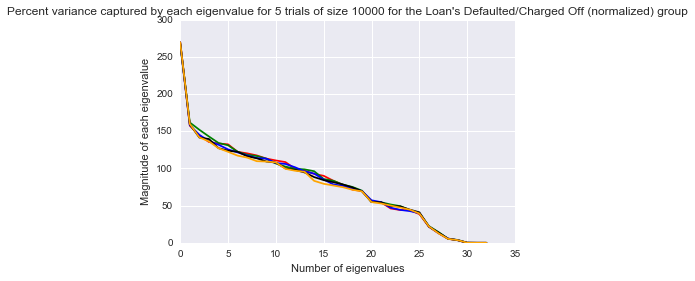

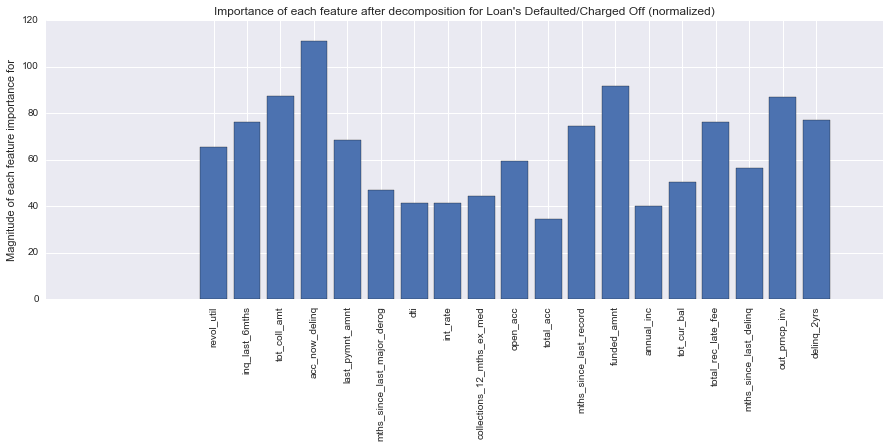

In [42]:
svd_variance_plot(5,10000,normal_loan_remove_col_default_chargedoff_df,"Loan's Defaulted/Charged Off (normalized)")

# Analysis
> After removing member id, and id, columns, the differences between the paid off and and charged/deafulted loans are:
- 1) People who pay off their loans have fewer significant features to explain 90% of the variance compared to people who default or charge off on their loans. (18 vs 22 for sample size 10000).
- 2) With a smaller sample size, 50 rows, there are only 15 features needed to explain 90% of the variance for Paid off loans, and only 18 features needed to explain 90% of the varince for Default/Charged off loans. The reason is with fewer rows, there is less chance of having values on the ends of your distribution which will increase the overall varince.
- 3) The additional features that help account for up to 90% variance for the deafulted/charged off loans versus the paid off loans are 
['recoveries', 'out_prncp_inv', 'open_acc', 'dti', 'tot_coll_amt']
- 4) The fact that there are more features required to explain the variance for default/charged off loans suggests that it is harder to identify loans that are going to default/charge off relative to loans that will be paid off.
- 5) The total matrix requires 21 columns to explain 90% of the variance. This makes sense, it should be between, or equal to, the number of features needed for the paid off loans the default/charged off loans.
- 6) One thing to note is the results of svd, number of components to explain a variance threshold, can differ depending on the type of standardization that you are using on your data. For example, if you don't standardize your data, the column with the largest magnitude of numbers will have the highest eigenvalue.

In [43]:
#Determine the difference in the number of columns present
default = ['mths_since_last_delinq', 'delinq_2yrs', 'recoveries', 'pub_rec', 'dti', 'inq_last_6mths', 'open_acc', 'last_pymnt_amnt', 'acc_now_delinq', 'tot_coll_amt', 'funded_amnt', 'total_rec_late_fee', 'annual_inc', 'tot_cur_bal', 'out_prncp_inv', 'collections_12_mths_ex_med']
paidoff = ['delinq_2yrs', 'tot_cur_bal', 'pub_rec', 'total_acc', 'total_rec_late_fee', 'revol_util', 'last_pymnt_amnt', 'acc_now_delinq', 'int_rate', 'collections_12_mths_ex_med', 'funded_amnt', 'annual_inc', 'total_rev_hi_lim', 'inq_last_6mths', 'mths_since_last_delinq']
#default_n = ['funded_amnt_inv', 'inq_last_6mths', 'total_pymnt_inv', 'mths_since_last_delinq', 'loan_amnt', 'int_rate', 'revol_util', 'delinq_2yrs', 'out_prncp_inv', 'total_acc', 'mths_since_last_record', 'revol_bal', 'installment', 'pub_rec', 'annual_inc', 'dti', 'total_pymnt', 'funded_amnt', 'open_acc', 'total_rec_prncp', 'out_prncp', 'total_rec_int']
print('The items that are different between the default/charged off loans and paid off are', list(set(default)-set(paidoff)))

The items that are different between the default/charged off loans and paid off are ['recoveries', 'tot_coll_amt', 'open_acc', 'dti', 'out_prncp_inv']


In [44]:
print('The items that are the same between the default/charged off and paid off loans are',(set(default).intersection(paidoff)))

The items that are the same between the default/charged off and paid off loans are {'inq_last_6mths', 'annual_inc', 'acc_now_delinq', 'last_pymnt_amnt', 'collections_12_mths_ex_med', 'pub_rec', 'tot_cur_bal', 'total_rec_late_fee', 'funded_amnt', 'mths_since_last_delinq', 'delinq_2yrs'}


# Next, compare the results of the SVD decomposition to PCA analysis.
>PCA differs from SVD because it computes SVD using a covariance matrix of the original data. Alternatively, PCA can find the eigenvalues and eigenvectors directly from the covariance matrix.



In [45]:
#The two dataframes we are working with. normal_loan_removecol_paid_df
#normal_loan_remove_col_default_chargedoff_df , total_remove_col_df



- ***First, build three methods for PCA.***
- 1)pca_variance_components_plot will plot an elbow graph of the eigenvalues from the covarince matrix and the magnitude of their importance. You can change the percent of variance that you want to retain in your original matrix and this function will tell you have many components are needed. This will return the number of components as well as the elbow graph.
- 2) pca_matrix_reduction_plot - Take your original matrix and reduce the dimensionality to the number of components needed for x% of varaince retained. Then, plot the data of the reduced dimensionality matrix to see the covaraince between elements.  This function can also return the components of a reduced matrix.
- 3)pca_matrix_original_vs_projected_plot - Take a sample of your original matrix project and plot.  Then, project the same festures along the principal component and plot.

In [46]:


def pca_variance_components_plot(original_matrix, variance_desired,name,graph=True):
    """Determine how many components account for your desired amount of variance. Return this number 
    of components. Graph the elbow plot of the explained variance for each component."""
    
    pca = PCA(n_components=np.shape(original_matrix)[1])
    pca.fit(original_matrix)
    var_pca = pca.explained_variance_ratio_
    
    count_of_components=1
    total_variance = 0
    
    if graph==False:
        for count,item in enumerate(var_pca):
            total_variance += var_pca[count]
            if total_variance > variance_desired:
                count_of_components+=1
                return("The first {} components account for {} percent of your variance for your {} matrix".format(count_of_components,total_variance,name),count_of_components)
    else:
        
        plt.plot(var_pca) ## plot variance explained by each components
        plt.title('Variance accounted for by each component for your {} matrix (the complete matrix)'.format(name))
        plt.ylabel('Variance of each component')
        plt.xlabel('Number of components')

        for count,item in enumerate(var_pca):
            total_variance += var_pca[count]

            if total_variance > variance_desired:
                count_of_components+=1
                #print(count_of_components)
                return("The first {} components account for {} percent of your variance for your {} matrix".format(count_of_components,total_variance,name),count_of_components)
                break
            else:
                count_of_components+=1
            
        
def pca_matrix_reduction_plot(original_matrix,variance_desired,name,pass_reduced=False,sample_size=0):
    """Reduce your original matrix to the number of components corresponding to your vaiance_desired.
    Return the list of columns that correspond to this level of accounted variance. Return the principal components
    if pass reduced is true."""
    
    #Compute PCA
    pca = PCA(n_components=np.shape(original_matrix)[1]-1)
    pca.fit(original_matrix)
    var_pca = pca.explained_variance_ratio_
    
    components=1
    total_variance = 0
    
    #Go through and find the explained variance up to your threshold
    
    for count,item in enumerate(var_pca):
            total_variance += var_pca[count]

            if total_variance > variance_desired:
                components+=1
            else:
                components+=1
    
    #Find the number of components you need
    pca= PCA(n_components=components)
    pca.fit(original_matrix)
    list_of_columns_in_df = list(original_matrix.columns)
    var_pca = pca.explained_variance_ratio_
    components_reduced_matrix = pca.components_
    
    reduced_matrix = pca.fit_transform(original_matrix)
    colors = ['r','r','g','r','b','b','k','k','orange','w','orange','navy','teal','maroon','w','m']
    if pass_reduced == True:

            return components_reduced_matrix  
        
    for count,item in enumerate(range(components)): ## plot the covariance
        plt.plot(reduced_matrix[:,count])
        plt.title('Results of PCA on the reduced {} matrix of size {} components'.format(name,components))
        plt.xlabel('Row number')
        plt.ylabel('Covariance between samples')
    

def pca_matrix_original_vs_projected_plot(original_matrix,name,sample_s=1000):
    """Compare the original normalized data between your original normalized data set 
    and projecting the original matrix along the principal component. Need at least four features."""
   
    
    sample_matrix = original_matrix.sample(sample_s)
    
    sample_matrix_columns = sample_matrix.columns
    
    
    X = sample_matrix_columns[0] ## Use the first feature for X
    
    Y=  sample_matrix_columns[3] ## Use the four feature for Y.
    
    components_of_reduced_pca_matrix = pca_matrix_reduction_plot(sample_matrix,.90,name+' Sample Matrix',pass_reduced=True,sample_size=sample_s)
    
    projected_component_one = components_of_reduced_pca_matrix[0]*sample_matrix.iloc[0]
    projected_component_two = components_of_reduced_pca_matrix[2]*sample_matrix.iloc[3]
    
    plt.figure()
 
    sns.regplot(X,Y,data=sample_matrix)
    
    # Original data without being projected
    plt.title("Original normalized data of {} for sample size {}".format(name,sample_s))
    plt.xlabel(sample_matrix_columns[0])
    plt.ylabel(sample_matrix_columns[3])

    
    #project along principal component
    plt.figure()
    sns.regplot(projected_component_one,projected_component_two)
    plt.title('Results of projecting {} and {} along the principal component for the {} matrix'.format(X,Y, name))
    plt.xlabel(sample_matrix_columns[0])
    plt.ylabel(sample_matrix_columns[3])
    

> Below are the results from the normalized load paid off matrix.

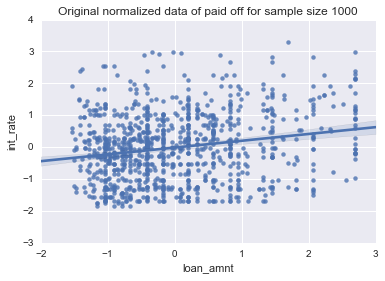

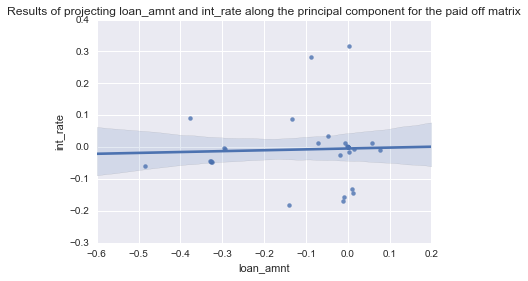

In [47]:
pca_matrix_original_vs_projected_plot(normal_loan_removecol_paid_df,'paid off',1000);

('The first 16 components account for 0.9103501105912004 percent of your variance for your paid off matrix',
 16)

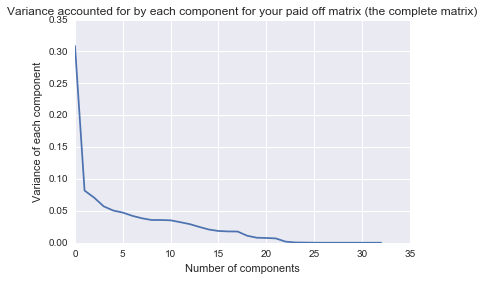

In [48]:
pca_variance_components_plot(normal_loan_removecol_paid_df,.90,'paid off')

> Next, look at the PCA analysis of the normalized matrix for loans that have defaulted or charged off.

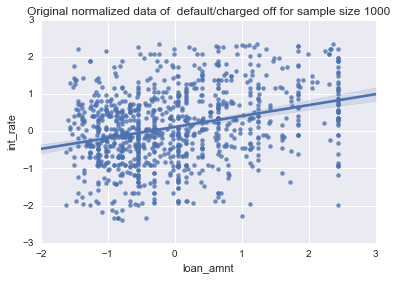

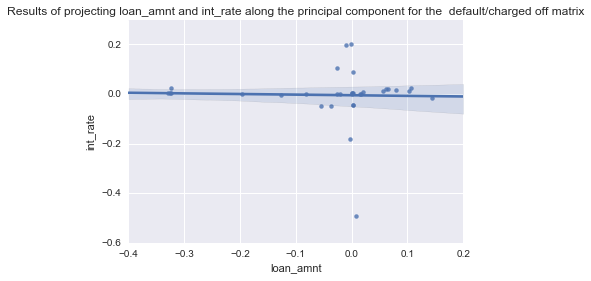

In [49]:
pca_matrix_original_vs_projected_plot(normal_loan_remove_col_default_chargedoff_df,' default/charged off',1000);

('The first 19 components account for 0.9120970392617396 percent of your variance for your default matrix',
 19)

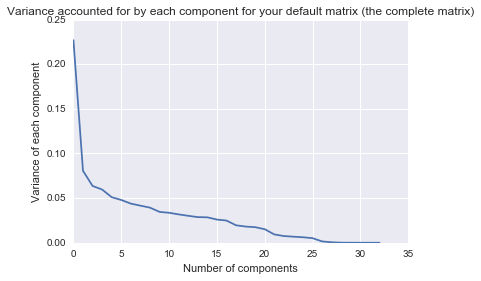

In [50]:
pca_variance_components_plot(normal_loan_remove_col_default_chargedoff_df,.90,'default')

> Finally, compare this to the total matrix.

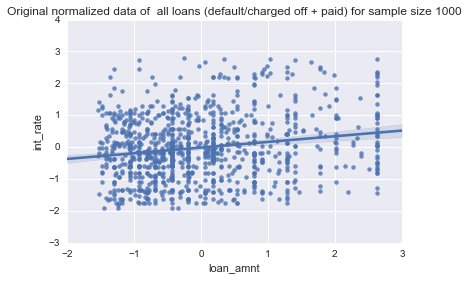

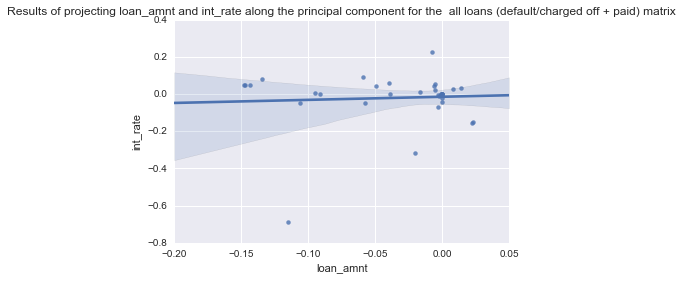

In [51]:
pca_matrix_original_vs_projected_plot(normal_total_remove_col_df,' all loans (default/charged off + paid)',1000);

('The first 19 components account for 0.9152005538378103 percent of your variance for your all loans (default/charged off + paid) matrix',
 19)

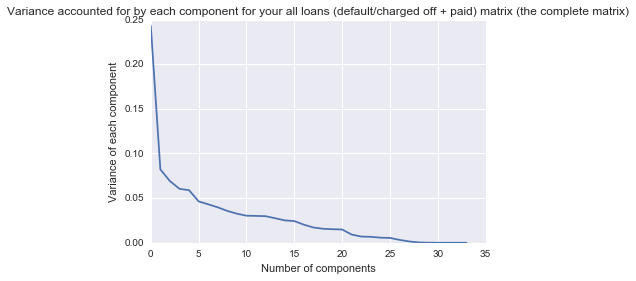

In [52]:
pca_variance_components_plot(normal_total_remove_col_df,.90,'all loans (default/charged off + paid)')

# Analysis
>For the PCA analysis of both groups of loans, paid off or deafaulted/charged off, we see the following attributes:
- 1)PCA reduces the number of features in the data by finding the principal directions of the matrix (removing columns that have a very high covariance to eachother). We can see this in the graph of the original data vs the projected data along the principal component. PCA reduces the amount of information needed to represent the original matrix. PCA also attempts to make variables uncorrelated to eachother which we can see in the linear regressions of the projected data.
- 2) In comparing the results from SVD and PCA, there are a different number of features that account for 90% of the variance in our data. 
    - A) For paid off loans, SVD identified 18 components needed to explain 90% of the data (with a sample size of 10,000) compared to 16 components for PCA.
    - B) For default/charged off loans, SVD identified 22 features to explain 90% of the data (with a sample size of 10,000), compared to 19 components for PCA.
    - The reason for the difference in the number of components needed to account for the same level of variance could be due to the following reason.
         - The PCA decomposition used the entire original matrix (for each group - paid off or default/charged off) while SVD used a sample of the original matrix (of size 10,000). This will be investigated below. 
- 3) The total matrix requires 19 components to describe 90% of the variance. This means that this matrix is heavily influenced by factors affecting people who default/charge off.
- 4) Unlike SVD, when we reconstruct PCA we have a covariance matrix with a reduced number of features (based upon our variance retained criterion). Therefore, we can only use PCA to understand the minimum number of dimensions we need to represent our original matrix. We can not, however, say which features are more or less important mapped back to our original matrix. 
* Note. There may be a difference in the number of components show for the elbow plot versus the normalized vectors. This is because the original normalized plot is looking at a **sample matrix** compared to the elbow plot that is looking at the total population matrix.

### Explore the differences of the sum of median values between a sample of 10,00 vs the original matrix for default/charged off and paid loans.

- First, examine default/charged off loans. Take the average of the median values and compare the differences between the sample and the original matrix.

In [53]:
normal_loan_remove_col_default_chargedoff_df.describe()

,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,...,recoveries,collection_recovery_fee,last_pymnt_amnt,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim
count,4.646700e+04,4.646700e+04,4.646700e+04,4.646700e+04,4.646700e+04,4.646700e+04,4.646700e+04,4.646700e+04,4.646700e+04,4.646700e+04,...,4.646700e+04,4.646700e+04,4.646700e+04,4.646700e+04,4.646700e+04,46467.0,4.646700e+04,4.646700e+04,4.646700e+04,4.646700e+04
mean,4.044741e-15,-1.571654e-15,1.261841e-15,-5.108025e-16,-1.103739e-15,5.655885e-17,6.558074e-16,2.119305e-14,-9.080142e-16,1.209436e-14,...,-1.584146e-14,-3.054381e-15,1.405035e-16,-2.303452e-14,5.365387e-14,0.0,-3.276901e-15,1.838808e-15,1.212536e-14,5.580178e-15
std,1.000011e+00,1.000011e+00,1.000011e+00,1.000011e+00,1.000011e+00,1.000011e+00,1.000011e+00,1.000011e+00,1.000011e+00,1.000011e+00,...,1.000011e+00,1.000011e+00,1.000011e+00,1.000011e+00,1.000011e+00,0.0,1.000011e+00,1.000011e+00,1.000011e+00,1.000011e+00
min,-1.629323e+00,-1.629049e+00,-1.717558e+00,-2.464197e+00,-1.699632e+00,-1.073597e+00,-2.319882e+00,-3.487079e-01,-8.692067e-01,-6.804262e-01,...,-5.561720e-01,-3.604115e-01,-6.999811e-01,-8.614897e-02,-4.282632e-01,0.0,-5.570235e-02,-9.103298e-02,-7.317475e-01,-8.282827e-01
25%,-7.832633e-01,-7.803788e-01,-7.641122e-01,-6.902881e-01,-7.101696e-01,-4.419133e-01,-7.338193e-01,-3.487079e-01,-8.692067e-01,-6.804262e-01,...,-5.561720e-01,-3.604115e-01,-3.340665e-01,-8.614897e-02,-4.282632e-01,0.0,-5.570235e-02,-9.103298e-02,-6.663797e-01,-6.242205e-01
50%,-2.231953e-01,-2.305359e-01,-2.397169e-01,-5.093704e-02,-2.022087e-01,-1.605397e-01,-8.079285e-03,-3.487079e-01,1.745970e-02,-6.804262e-01,...,-5.457530e-01,-3.604115e-01,-1.217176e-01,-8.614897e-02,-4.282632e-01,0.0,-5.570235e-02,-9.103298e-02,-4.327625e-01,-1.960900e-01
75%,6.466976e-01,6.539940e-01,6.630773e-01,6.744358e-01,5.358662e-01,2.263489e-01,7.164029e-01,-3.487079e-01,9.041261e-01,5.181900e-01,...,2.223114e-01,-2.619555e-01,1.749217e-01,-8.614897e-02,-4.282632e-01,0.0,-5.570235e-02,-9.103298e-02,3.931643e-01,3.280698e-01
max,2.434149e+00,2.446960e+00,2.453768e+00,3.015623e+00,3.985146e+00,1.519673e+02,2.708729e+00,2.216819e+01,6.224125e+00,6.067339e+00,...,2.093594e+01,2.730940e+01,5.288855e+01,4.150434e+01,7.375157e+00,0.0,7.066345e+01,8.300809e+01,2.732439e+01,7.914410e+01


In [54]:
#Look at the median numbers for default/charged off loans
normal_loan_remove_col_default_chargedoff_df.describe()[normal_loan_remove_col_default_chargedoff_df.describe().index=='50%']

,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,...,recoveries,collection_recovery_fee,last_pymnt_amnt,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim
50%,-0.223195,-0.230536,-0.239717,-0.050937,-0.202209,-0.16054,-0.008079,-0.348708,0.01746,-0.680426,...,-0.545753,-0.360411,-0.121718,-0.086149,-0.428263,0.0,-0.055702,-0.091033,-0.432762,-0.19609


In [55]:
#Take the sum of the median values
sum_50_normal_default_charged_off = sum(sum(normal_loan_remove_col_default_chargedoff_df.describe()[normal_loan_remove_col_default_chargedoff_df.describe().index=='50%']))
sum_50_normal_default_charged_off

-7.264425105004517

In [56]:
#Take a sample of the original matrix and look at the median values
normal_loan_remove_col_default_chargedoff_df_sample = normal_loan_remove_col_default_chargedoff_df.sample(10000)
normal_loan_remove_col_default_chargedoff_df_sample.describe()[normal_loan_remove_col_default_chargedoff_df_sample.describe().index=='50%']

,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,...,recoveries,collection_recovery_fee,last_pymnt_amnt,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim
50%,-0.247028,-0.242489,-0.254614,-0.050937,-0.214567,-0.16054,-0.023802,-0.348708,0.01746,-0.680426,...,-0.543038,-0.358791,-0.129064,-0.086149,-0.428263,0.0,-0.055702,-0.091033,-0.428514,-0.19609


In [57]:
#Take the sum of the sample median values
sum_sample_50_normal_default_charged_off = sum(np.sum(normal_loan_remove_col_default_chargedoff_df_sample.describe()[normal_loan_remove_col_default_chargedoff_df_sample.describe().index=='50%']))
sum_sample_50_normal_default_charged_off 

-7.338507920582085

In [58]:
#Compare the difference between the sample and the original matrix
sum_sample_50_normal_default_charged_off  -sum_50_normal_default_charged_off

-0.0740828155775679

## The difference in the sum of the median values of the matrices (for the default/charged off group) is -0.19082048270514118 To test if this is significant, a t-test can be performed.

##### Notice, one is used to compute the standard error because normalizing to a standard scalar sets variance of each columns to 1.

In [59]:
#Compute the t-value
t_value_50_default_charged_off =(sum_sample_50_normal_default_charged_off  - sum_50_normal_default_charged_off) \
/ (1 /sqrt(10000))

t_value_50_default_charged_off

-7.4082815577567906

In [60]:
#Determine the p-value of the t-test
t(10000-1).cdf(t_value_50_default_charged_off)

6.9145663622973862e-14

#### The p-value of the differences is .4.6118326942090309e-80, which means that there is a significant difference between the standard deviation of our sample and our population. This explains the difference in the number of components between SVD and PCA for the default/charged off group.

## Next, do a t-test for the sum of median values of paid off loans. 

> #### Note, the value one is used again due to the normalization of our data using standard scalars for computing t-values.

In [61]:
#Examine the median values for the original matrix
normal_loan_removecol_paid_df.describe()[normal_loan_removecol_paid_df.describe().index=='50%']

,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,...,recoveries,collection_recovery_fee,last_pymnt_amnt,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim
50%,-0.167096,-0.162628,-0.185601,-0.038479,-0.217417,-0.169256,-0.050565,-0.335063,-0.784016,-0.688007,...,0.0,0.0,-0.26913,-0.073389,-0.420022,0.0,-0.050626,-0.008095,-0.455575,-0.224205


In [62]:
#Take the sum of the median values for the original matrix
sum_50_normal_paidoff = sum(np.sum(normal_loan_removecol_paid_df.describe()[normal_loan_removecol_paid_df.describe().index=='50%']))
sum_50_normal_paidoff

-6.4759121631146455

In [63]:
#Look at the median values for the sample matrix
normal_loan_removecol_paid_sample_df = normal_loan_removecol_paid_df.sample(10000)
normal_loan_removecol_paid_sample_df.describe()[normal_loan_removecol_paid_sample_df.describe().index=='50%']

,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,...,recoveries,collection_recovery_fee,last_pymnt_amnt,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim
50%,-0.167096,-0.162628,-0.154559,-0.038479,-0.196041,-0.171998,-0.049266,-0.335063,-0.784016,-0.688007,...,0.0,0.0,-0.254178,-0.073389,-0.420022,0.0,-0.050626,-0.008095,-0.460137,-0.218102


In [64]:
#Take the sum of the median values for the sample matrix
sum_sample_50_paidoff = sum(np.sum(normal_loan_removecol_paid_sample_df.describe()[normal_loan_removecol_paid_sample_df.describe().index=='50%']))
sum_sample_50_paidoff

-6.3641486738868

In [65]:
#Find the difference between the two
sum_sample_50_paidoff - sum_50_normal_paidoff 

0.11176348922784562

In [66]:
#Compute the t-value
t_value_50_paidoff =(sum_sample_50_paidoff  - sum_50_normal_paidoff ) \
/ (1 /sqrt(10000))

t_value_50_paidoff

11.176348922784562

In [67]:
#Get the p-value
1-t(10000-1).cdf(t_value_50_paidoff)

0.0

#### For our paid off group, there is an every more significant difference in the sum of median values between the sample and original matrix. This also is a likely candidate for explaining the different in the number of component features between SVD and PCA.
- The reason why the p-values differ so significantly is due to the differences in the size of the original matrix for default/charged off loans (46,467) vs paid off loans (207,723). 

# Prediction

> Below is some test code to understand how to project samples of data from our test set onto the primary eigenvector of our training decomposition. We will examine the first user from a sample of 5,000 users in our test data between default/charged off and paid off and examine the euclidean distance that each primary eigenvector (for default/charged off or paid) projects this data.
- Vt is from the decomponsition of the our training data for either default/paid off. 


### Example Code
#### First, use default/charged off

In [68]:
#Test data
test_5k_default = normal_loan_remove_col_default_chargedoff_df.sample(5000)
test_5k_paid = normal_loan_removecol_paid_df.sample(5000)

In [69]:

#default group projections

u_default,d_default,v_t_default = svd_variance_plot(5,10000,normal_loan_remove_col_default_chargedoff_df,"Loan's Defaulted/Charged Off (normalized)",.9,True)

###testing the default / charged off
print("This is the  Euclidean distance between each element in the test vector for the default group\n, and the vector projected onto the primary eigenvector for default\
 charged off group decomposition",sqrt(sum([(x-y)**2 for (x,y) in zip(test_5k_default.iloc[5], (test_5k_default.iloc[5]*abs(v_t_default[0])))])))

This is the  Euclidean distance between each element in the test vector for the default group
, and the vector projected onto the primary eigenvector for default charged off group decomposition 3.87848417887


In [70]:

#### paid off
u_paid,d_paid,v_t_paid = svd_variance_plot(5,10000,normal_loan_removecol_paid_df,"Loan's Defaulted/Charged Off (normalized)",.9,True)


###testing the paid off error of the default sample

print("This is the Euclidean distance between each element in the test vector for the default group,\n and the vector projected onto the \
primary eigenvector  for default/charged off group decomposition", \
      sqrt(sum([(x-y)**2 for (x,y) in zip(test_5k_default.iloc[5], (test_5k_default.iloc[5]*abs(v_t_paid[0])))])))

This is the Euclidean distance between each element in the test vector for the default group,
 and the vector projected onto the primary eigenvector  for default/charged off group decomposition 3.876397675


### Whichever number is smaller above is the group we would predict this user would belong to.


### Now, apply to our data.

In [71]:
print(np.shape(normal_loan_remove_col_default_chargedoff_df))
print(np.shape(normal_loan_removecol_paid_df))

(46467, 33)
(207723, 33)


In [72]:
# training data for default/charged off loans

In [73]:
def svd_prediction(default_charged_off_df,paidoff_df,percent_to_use_for_training=.5,rows_to_test=2000):
    """ Take X percent of data from the two dataframes and see what group each user should below to by projecting
    along the primary eigenvector. Max training size of 40k rows"""
    
    #shuffle the matrices so that we are sampling random rows
    default_charged_off_df = shuffle(default_charged_off_df)
    paidoff_df = shuffle(paidoff_df)
    
    shape_default = np.shape(default_charged_off_df)
    shape_paid = np.shape(paidoff_df)
    training_default_rows = round(percent_to_use_for_training*100000)
    training_paid_rows = round(percent_to_use_for_training*100000)
    
    #Set of threshold of 40k rows so that the local machine doesn't die.
    if training_default_rows >40000: training_default_rows=40000
    if training_paid_rows>40000:training_paid_rows=40000
        
    #default training and paid training rows from the randomized matrix
    default_training = default_charged_off_df.iloc[0:training_default_rows] ### take these rows to train SVD
    paid_training = paidoff_df.iloc[0:training_paid_rows] ### take these rows to train SVD
    
    #default test and paid test rows. Making sure NOT to include rows that were in our training data
    default_test = default_charged_off_df.iloc[(training_default_rows+1):(training_default_rows+rows_to_test)]
    paid_test = paidoff_df.iloc[(training_paid_rows+1):(training_paid_rows+rows_to_test)]
                                                                      
    #Decomposition
    #This will give us the v_t matrix for our training set of deault loans + paid loans
    u_default,d_default,v_t_default = np.linalg.svd(default_training)
    u_paid,d_paid,v_t_paid = np.linalg.svd(paid_training)
    
    ###testing the default / charged off projections
    
    correct_prediction_default=0
    correct_prediction_paid=0
    
    
    for count,row in default_test.iterrows(): 
        ## test the default svd with a default test group, measure the distance using Euclidean distance
        row = np.array(row)
        
        #Euclidean distance between the vector and the projection
        default_predict_default_difference = sqrt(sum([(x-y)**2 for (x,y) in zip(row, (row*abs(v_t_default[0])))]))
        default_predict_paid_difference =sqrt(sum([(x-y)**2 for (x,y) in zip(row, (row*abs(v_t_paid[0])))]))
        if default_predict_default_difference < default_predict_paid_difference:
            correct_prediction_default+=1
    print(correct_prediction_default,'People correctly predicted to be in the default group')
    print()
    
    for count,row in paid_test.iterrows(): ## test the paid svd
        row = np.array(row)
        
        #Euclidean distance between two vectors
        paid_predictby_default_difference = sqrt(sum([(x-y)**2 for (x,y) in zip(row, (row*abs(v_t_default[0])))]))
        paid_predictby_paid_difference =sqrt(sum([(x-y)**2 for (x,y) in zip(row, (row*abs(v_t_paid[0])))]))

        
        if paid_predictby_default_difference > paid_predictby_paid_difference:
            correct_prediction_paid+=1
    print(correct_prediction_paid,'People correctly predicted to be in the paid group')
    
    #subtract two here bacause we start at row +1 and do not include the last index. This gives the prediction percent. 
    print(" ")
    print(correct_prediction_default/(rows_to_test-2)*100,"Percent of people in the default \
    group correctly predicted by the default group with training size {} and test size {}".format(training_default_rows,rows_to_test))
    
    print(correct_prediction_paid/(rows_to_test-2)*100,"Percent of people in the paid\
    group correctly predicted by the paid group with training size {} and test size {}".format(training_paid_rows, rows_to_test))
        

In [76]:
svd_prediction(normal_loan_remove_col_default_chargedoff_df,normal_loan_removecol_paid_df,.01)

1512 People correctly predicted to be in the default group

1360 People correctly predicted to be in the paid group
 
75.67567567567568 Percent of people in the default     group correctly predicted by the default group with training size 1000 and test size 2000
68.06806806806807 Percent of people in the paid    group correctly predicted by the paid group with training size 1000 and test size 2000


In [77]:
svd_prediction(normal_loan_remove_col_default_chargedoff_df,normal_loan_removecol_paid_df,.03)

1782 People correctly predicted to be in the default group

1048 People correctly predicted to be in the paid group
 
89.1891891891892 Percent of people in the default     group correctly predicted by the default group with training size 3000 and test size 2000
52.45245245245245 Percent of people in the paid    group correctly predicted by the paid group with training size 3000 and test size 2000


In [78]:
svd_prediction(normal_loan_remove_col_default_chargedoff_df,normal_loan_removecol_paid_df,.05)

1734 People correctly predicted to be in the default group

1044 People correctly predicted to be in the paid group
 
86.78678678678679 Percent of people in the default     group correctly predicted by the default group with training size 5000 and test size 2000
52.25225225225225 Percent of people in the paid    group correctly predicted by the paid group with training size 5000 and test size 2000


In [79]:
svd_prediction(normal_loan_remove_col_default_chargedoff_df,normal_loan_removecol_paid_df,.08)

1622 People correctly predicted to be in the default group

1116 People correctly predicted to be in the paid group
 
81.18118118118119 Percent of people in the default     group correctly predicted by the default group with training size 8000 and test size 2000
55.85585585585585 Percent of people in the paid    group correctly predicted by the paid group with training size 8000 and test size 2000


In [80]:
svd_prediction(normal_loan_remove_col_default_chargedoff_df,normal_loan_removecol_paid_df,.1)

1570 People correctly predicted to be in the default group

1577 People correctly predicted to be in the paid group
 
78.57857857857859 Percent of people in the default     group correctly predicted by the default group with training size 10000 and test size 2000
78.92892892892893 Percent of people in the paid    group correctly predicted by the paid group with training size 10000 and test size 2000


In [83]:
svd_prediction(normal_loan_remove_col_default_chargedoff_df,normal_loan_removecol_paid_df,.12)

1694 People correctly predicted to be in the default group

1395 People correctly predicted to be in the paid group
 
84.78478478478479 Percent of people in the default     group correctly predicted by the default group with training size 12000 and test size 2000
69.81981981981981 Percent of people in the paid    group correctly predicted by the paid group with training size 12000 and test size 2000


In [82]:
svd_prediction(normal_loan_remove_col_default_chargedoff_df,normal_loan_removecol_paid_df,.15)

1742 People correctly predicted to be in the default group

1013 People correctly predicted to be in the paid group
 
87.18718718718719 Percent of people in the default     group correctly predicted by the default group with training size 15000 and test size 2000
50.70070070070069 Percent of people in the paid    group correctly predicted by the paid group with training size 15000 and test size 2000
